<a href="https://colab.research.google.com/github/AishwaryaVelumani/Deep-Learning/blob/master/Image_Classification_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset: Cats vs Dogs
**Raw data download**

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   143M      0  0:00:05  0:00:05 --:--:--  146M


In [4]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [5]:
!ls PetImages
#There is a PetImages folder which has 2 subfolders Cat and Dog. Each subfolder contains image dataset
#for each category.

Cat  Dog


**Filter out corrupt images**

In [6]:
#filtering out corrupt images that don't feature the string 'JFIF' in their header
import os 

num_skipped=0
for folder_name in ("Cat","Dog"):
    folder_path= os.path.join("PetImages",folder_name)
    for fname in os.listdir(folder_path):
        fpath= os.path.join(folder_path,fname)
        try:
            fobj= open(fpath,"rb")
            is_jfif= tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped+=1
            #delete corrupted file
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [7]:
'''#while True:
try:
    x=int(input("Enter:"))
    #break
except ValueError:
    print("Oops!")'''

'#while True:\ntry:\n    x=int(input("Enter:"))\n    #break\nexcept ValueError:\n    print("Oops!")'

# Generate a dataset

In [8]:
image_size=(180,180)
batch_size=32

train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


# Visualize the data

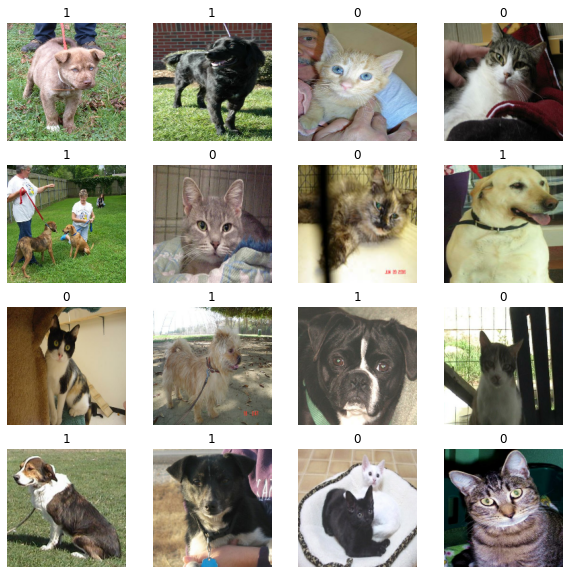

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
    for i in range(16):
        ax=plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Using image data augmentation

In [10]:
data_augmentation= keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.1),
     layers.experimental.preprocessing.RandomZoom(0.1,0.1)
    ]
)

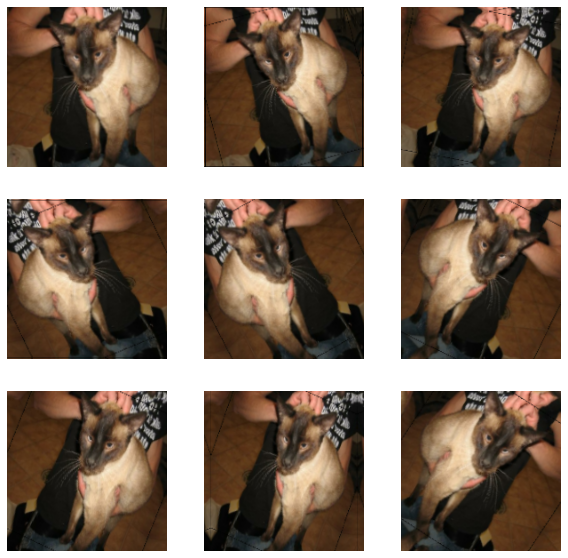

In [11]:
#Visualizing data augmentation on the 1st image
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images= data_augmentation(images)
        ax= plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Standardizing the data

In [12]:
#our images are in the standard size of 180 by 180 and yielded as contiguous float32 batches of RBG channel values 
#in the range of [0,255]. This isn't ideal for neural networks, in general they require that their input values 
#be small. Hence we standardize our values in the range of [0,1] by using Rescaling layer at the start of our model.

#Since we are training on GPU, we will make the data_augmentation preprocessor as part of our model

#inputs= keras.Input(shape=input_shape)
#x= data_augmentation(inputs)
#x= layers.experimental.preprocessing.Rescaling(1./255)(x)

#If training on CPU, we can apply data_augmentation to the dataset

# Configure the dataset for performance

In [13]:
#using buffered prefetching so that we can yield data from disk without IO blocking

train_ds= train_ds.prefetch(buffer_size=32)
val_ds= val_ds.prefetch(buffer_size=32)

# Build a model

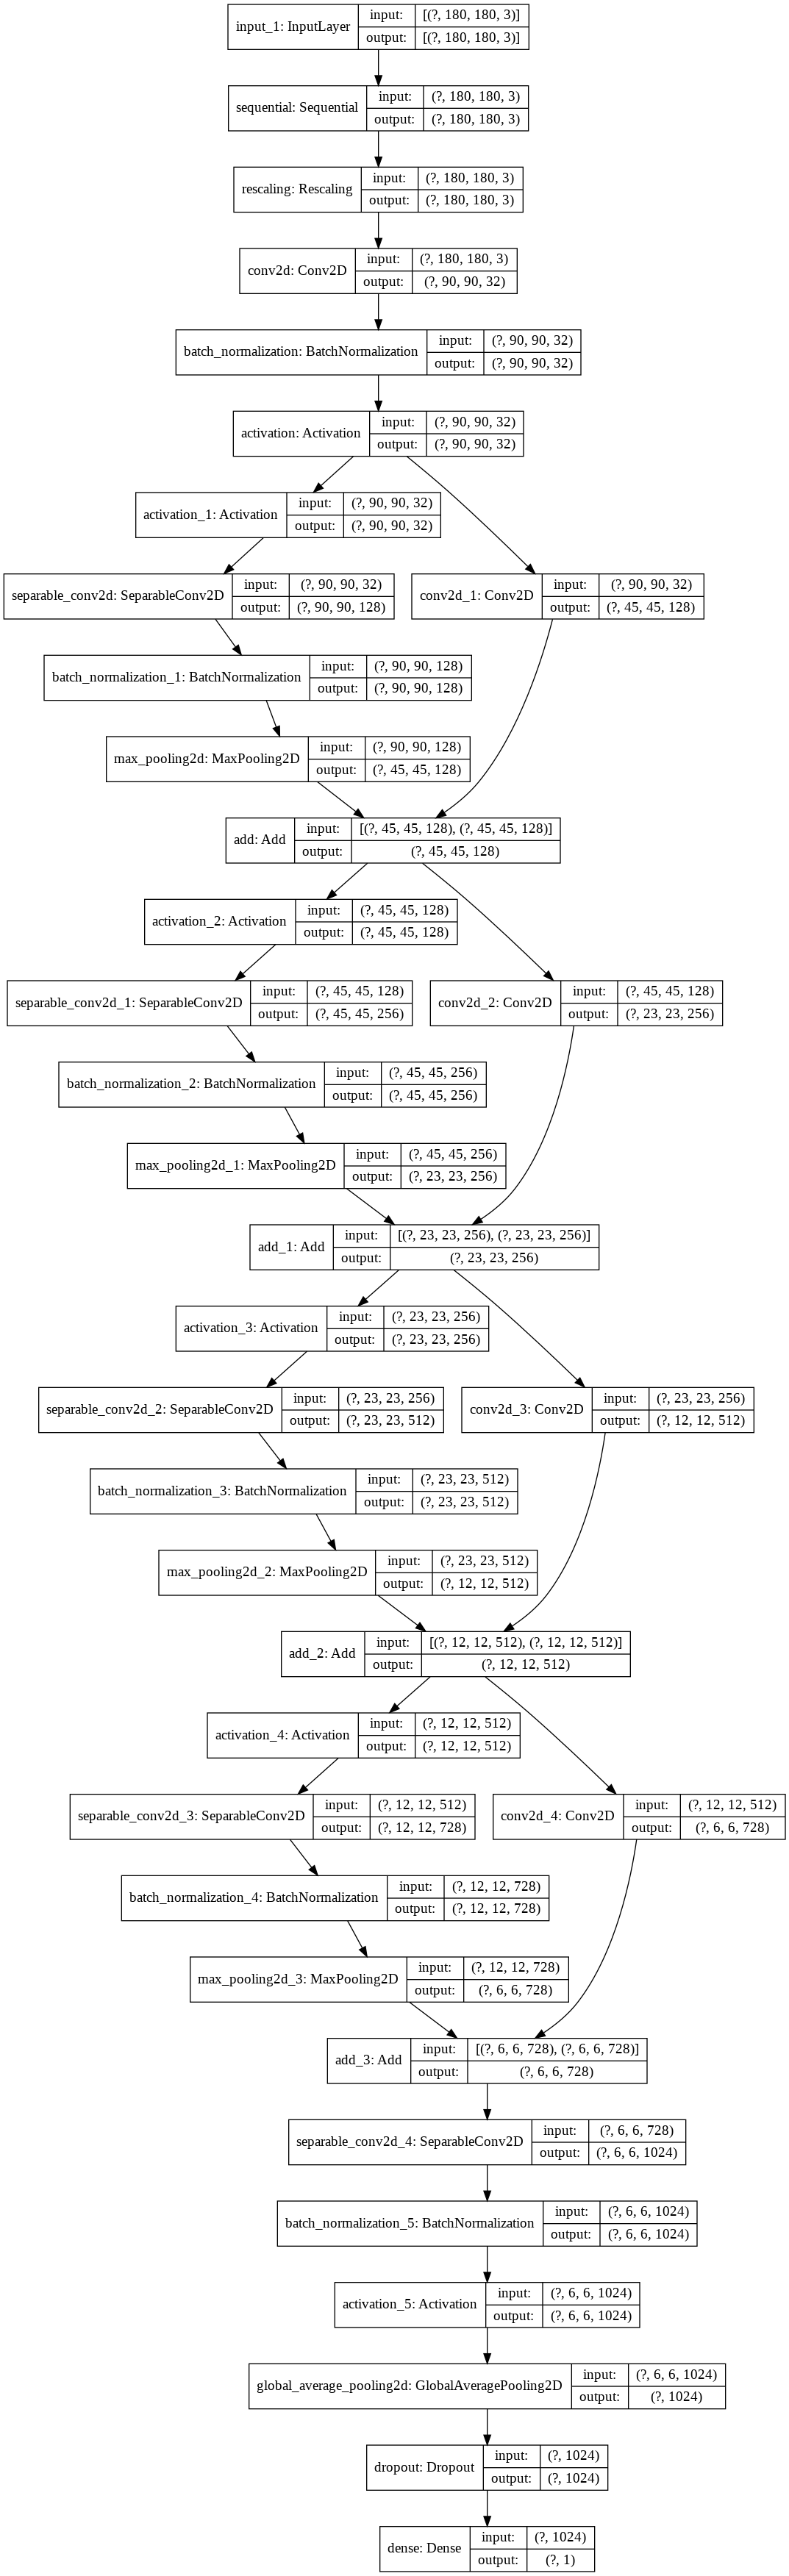

In [14]:
def make_model(input_shape,num_classes):
    inputs= keras.Input(shape= input_shape)
    x= data_augmentation(inputs)
    
    #Entry block
    x= layers.experimental.preprocessing.Rescaling(1./255)(x)
    x= layers.Conv2D(32,3,strides=2,padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.Activation("relu")(x)

    previous_block_activation= x  #set aside residual

    for size in [128,256,512,728]:
        x= layers.Activation("relu")(x)
        x= layers.SeparableConv2D(size,3,padding="same")(x)
        x= layers.BatchNormalization()(x)

        x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

        #project residual
        residual= layers.Conv2D(size,1,strides=2,padding="same")(previous_block_activation)
        x= layers.add([x,residual])  #add back residual
        previous_block_activation= x  #set aside next residual

    x= layers.SeparableConv2D(1024,3,padding="same")(x)
    x= layers.BatchNormalization()(x)
    x= layers.Activation("relu")(x)

    x=layers.GlobalAveragePooling2D()(x)

    if num_classes==2:
        activation= "sigmoid"
        units=1
    else:
        activation= "softmax"
        units= num_classes

    x= layers.Dropout(0.5)(x)
    outputs= layers.Dense(units,activation=activation)(x)
    return keras.Model(inputs,outputs)

model= make_model(input_shape=image_size +(3,), num_classes=2)
keras.utils.plot_model(model,show_shapes=True)

# Train the model

In [16]:
epochs= 10 # 50 epochs gives 96% accuracy

callbacks= [
            keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer= keras.optimizers.Adam(1e-3),
    loss= "binary_crossentropy",
    metrics= ["accuracy"],
)

model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds,
)

Epoch 1/10
586/586 [==============================] - 123s 209ms/step - loss: 0.2381 - accuracy: 0.9017 - val_loss: 0.3045 - val_accuracy: 0.8689
Epoch 2/10
586/586 [==============================] - 123s 209ms/step - loss: 0.2212 - accuracy: 0.9097 - val_loss: 0.2040 - val_accuracy: 0.9193
Epoch 3/10
586/586 [==============================] - 122s 209ms/step - loss: 0.2136 - accuracy: 0.9112 - val_loss: 0.3626 - val_accuracy: 0.8578
Epoch 4/10
586/586 [==============================] - 123s 210ms/step - loss: 0.2024 - accuracy: 0.9165 - val_loss: 0.3442 - val_accuracy: 0.8454
Epoch 5/10
586/586 [==============================] - 122s 208ms/step - loss: 0.1978 - accuracy: 0.9198 - val_loss: 0.1866 - val_accuracy: 0.9212
Epoch 6/10
586/586 [==============================] - 123s 209ms/step - loss: 0.1858 - accuracy: 0.9226 - val_loss: 0.1742 - val_accuracy: 0.9299
Epoch 7/10
586/586 [==============================] - 122s 209ms/step - loss: 0.1883 - accuracy: 0.9240 - val_loss: 0.2286 -

# Run inference on new data

This image is 0.01 percent cat and 99.99 percent dog


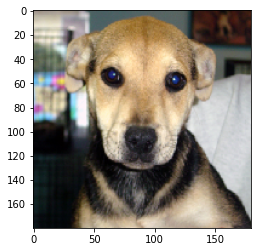

In [32]:
#data augmentation and droupout are inactive during inference time

img= keras.preprocessing.image.load_img(
    "PetImages/Dog/4.jpg",
    target_size=image_size
)

img_array= keras.preprocessing.image.img_to_array(img) #3d numpy array
img_array= tf.expand_dims(img_array,0)  #create batch axis

predictions= model.predict(img_array)
score= predictions[0]
plt.imshow(img)
print("This image is %.2f percent cat and %.2f percent dog" % (100* (1-score) , 100*score) )
